In [ ]:
from dataset import HandSegDataset
import torchvision.transforms as T
from torch.utils.data import DataLoader

train_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor()
])

test_transform = T.Compose([
    T.Resize((256,256)),
    T.ToTensor()
])

train_dataset = HandSegDataset("data/train/images", "data/train/masks", transform=train_transform)
test_dataset  = HandSegDataset("data/test/images",  "data/test/masks",  transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

print("Datasets created.")
print("Train set size:", len(train_dataset))
print("Test set size:", len(test_dataset))

Datasets created.
Train set size: 2011
Test set size: 784


## DeepLabv3

In [ ]:
import torchvision
import torch
import torch.nn as nn

def create_deeplabv3(num_classes=2, pretrained=True):
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=pretrained)
    # Replace final classifier
    model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
    return model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

model = create_deeplabv3(num_classes=2, pretrained=True).to(device)

Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 87.3MB/s]


In [ ]:
import torch.optim as optim
train_losses = []

num_epochs = 5
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks  = masks.to(device)

        outputs = model(images)['out']
        loss = criterion(outputs, masks.squeeze(1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

Epoch [1/5] - Loss: 0.0782
Epoch [2/5] - Loss: 0.0442
Epoch [3/5] - Loss: 0.0358
Epoch [4/5] - Loss: 0.0321
Epoch [5/5] - Loss: 0.0341


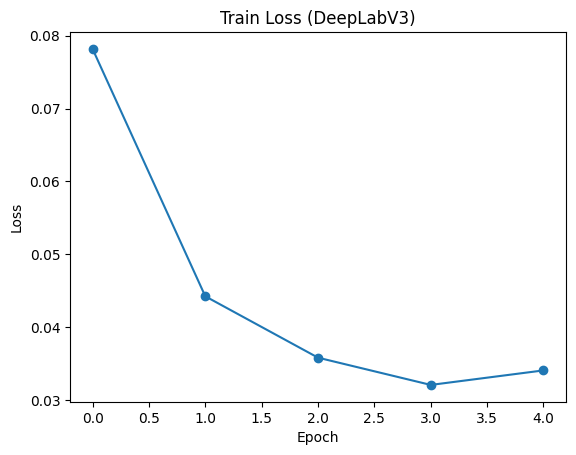

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, marker='o')
plt.title("Train Loss (DeepLabV3)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


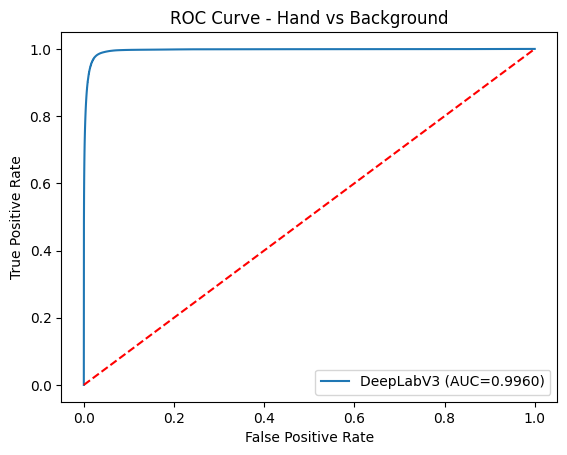

AUC = 0.9960286080842096


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch.nn.functional as F

model.eval()
all_probs = []
all_labels = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks  = masks.to(device)  # shape (B,1,H,W)

        outputs = model(images)['out']  # (B,2,H,W)
        probs = F.softmax(outputs, dim=1)  # (B,2,H,W)

        # Probability of "hand" is index 1
        probs_hand = probs[:,1,:,:].cpu().numpy().ravel()
        labels = masks.cpu().numpy().ravel()  # 0 or 1
        all_probs.append(probs_hand)
        all_labels.append(labels)

all_probs  = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

# Compute ROC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"DeepLabV3 (AUC={roc_auc:.4f})")
plt.plot([0,1],[0,1], 'r--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hand vs Background")
plt.legend()
plt.show()

print("AUC =", roc_auc)

In [ ]:
torch.save(model.state_dict(), "models/deeplabv3.pth")

# Load
# model = create_deeplabv3(num_classes=2, pretrained=False).to(device)
# model.load_state_dict(torch.load("model.pth"))
# model.eval()

## UNet

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """
    (Conv => BN => ReLU) x 2
    """
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, num_classes=2, in_channels=3, base_c=64):
        super().__init__()
        # Down/encoder
        self.dc1 = DoubleConv(in_channels, base_c)      # 3 -> 64
        self.dc2 = DoubleConv(base_c, base_c*2)         # 64 -> 128
        self.dc3 = DoubleConv(base_c*2, base_c*4)       # 128 -> 256
        self.dc4 = DoubleConv(base_c*4, base_c*8)       # 256 -> 512

        # Bottleneck
        self.dc5 = DoubleConv(base_c*8, base_c*16)      # 512 -> 1024

        # Up/decoder
        self.up4 = nn.ConvTranspose2d(base_c*16, base_c*8, kernel_size=2, stride=2)
        self.uc4 = DoubleConv(base_c*16, base_c*8)      # skip + up

        self.up3 = nn.ConvTranspose2d(base_c*8, base_c*4, kernel_size=2, stride=2)
        self.uc3 = DoubleConv(base_c*8, base_c*4)

        self.up2 = nn.ConvTranspose2d(base_c*4, base_c*2, kernel_size=2, stride=2)
        self.uc2 = DoubleConv(base_c*4, base_c*2)

        self.up1 = nn.ConvTranspose2d(base_c*2, base_c, kernel_size=2, stride=2)
        self.uc1 = DoubleConv(base_c*2, base_c)

        self.out_conv = nn.Conv2d(base_c, num_classes, kernel_size=1)
        # Pool for downsampling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder
        c1 = self.dc1(x)       # [B,64,H,W]
        p1 = self.pool(c1)     # [B,64,H/2,W/2]

        c2 = self.dc2(p1)      # [B,128,H/2,W/2]
        p2 = self.pool(c2)     # [B,128,H/4,W/4]

        c3 = self.dc3(p2)      # [B,256,H/4,W/4]
        p3 = self.pool(c3)     # [B,256,H/8,W/8]

        c4 = self.dc4(p3)      # [B,512,H/8,W/8]
        p4 = self.pool(c4)     # [B,512,H/16,W/16]

        # Bottleneck
        c5 = self.dc5(p4)      # [B,1024,H/16,W/16]

        # Decoder
        u4 = self.up4(c5)      # [B,512,H/8,W/8]
        cat4 = torch.cat([u4, c4], dim=1)  # skip connection
        c6 = self.uc4(cat4)    # [B,512,H/8,W/8]

        u3 = self.up3(c6)      # [B,256,H/4,W/4]
        cat3 = torch.cat([u3, c3], dim=1)
        c7 = self.uc3(cat3)    # [B,256,H/4,W/4]

        u2 = self.up2(c7)      # [B,128,H/2,W/2]
        cat2 = torch.cat([u2, c2], dim=1)
        c8 = self.uc2(cat2)    # [B,128,H/2,W/2]

        u1 = self.up1(c8)      # [B,64,H,W]
        cat1 = torch.cat([u1, c1], dim=1)
        c9 = self.uc1(cat1)    # [B,64,H,W]

        # Output
        out = self.out_conv(c9)  # [B, num_classes, H, W]
        return out


In [ ]:
model_unet = UNet(num_classes=2, in_channels=3, base_c=64).to(device)
print("Number of parameters:", sum(p.numel() for p in model_unet.parameters()))

Number of parameters: 31043586


In [ ]:
from torchsummary import summary
summary(model_unet, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
        DoubleConv-7         [-1, 64, 256, 256]               0
         MaxPool2d-8         [-1, 64, 128, 128]               0
            Conv2d-9        [-1, 128, 128, 128]          73,856
      BatchNorm2d-10        [-1, 128, 128, 128]             256
             ReLU-11        [-1, 128, 128, 128]               0
           Conv2d-12        [-1, 128, 128, 128]         147,584
      BatchNorm2d-13        [-1, 128, 128, 128]             256
             ReLU-14        [-1, 128, 1

In [ ]:
optimizer = torch.optim.Adam(model_unet.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
num_epochs = 5  
train_losses = []
for epoch in range(num_epochs):
    model_unet.train()
    running_loss = 0.0
    total_loss = 0.0
    for images, masks in train_loader:  
        images = images.to(device) # [B,3,H,W]
        masks  = masks.to(device)  # [B,1,H,W]

        outputs = model_unet(images)  # [B,2,H,W]
        loss = criterion(outputs, masks.squeeze(1))  
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    epoch_loss = running_loss / len(train_loader)
    print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")

[Epoch 1/5] Loss: 0.1961
[Epoch 2/5] Loss: 0.0940
[Epoch 3/5] Loss: 0.0715
[Epoch 4/5] Loss: 0.0590
[Epoch 5/5] Loss: 0.0529


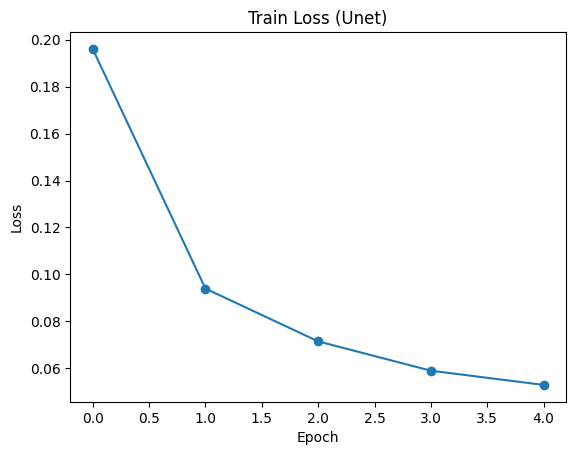

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(train_losses, marker='o')
plt.title("Train Loss (Unet)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model_unet.state_dict(), "models/unet.pth")
# load
# loaded_unet = UNet(num_classes=2, in_channels=3, base_c=64)
# loaded_unet.load_state_dict(torch.load("unet.pth"))
# loaded_unet.eval()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

model_unet.eval()  
all_probs = []
all_labels = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)   # (B, 3, H, W)
        masks  = masks.to(device)    # (B, 1, H, W)

        logits = model_unet(images)  # [B,2,H,W]

        probs = F.softmax(logits, dim=1)  # (B, 2, H, W)
        probs_hand = probs[:, 1, :, :].detach().cpu().numpy().ravel()
        labels = masks.cpu().numpy().ravel()

        all_probs.append(probs_hand)
        all_labels.append(labels)

all_probs  = np.concatenate(all_probs)
all_labels = np.concatenate(all_labels)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


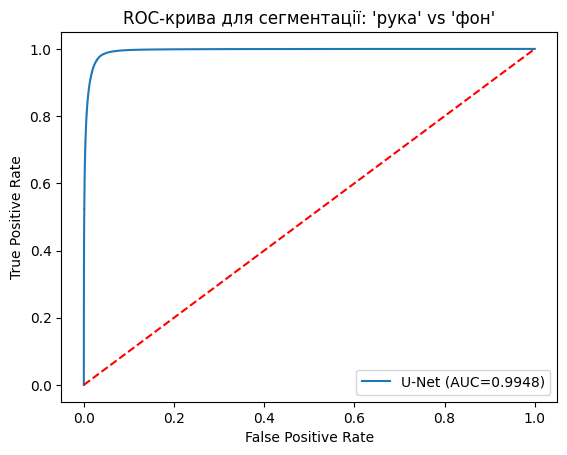

AUC = 0.9948293379773767


In [ ]:
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"U-Net (AUC={roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'r--')  # діагональ
plt.title("ROC-крива для сегментації: 'рука' vs 'фон'")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

print("AUC =", roc_auc)